# Resistance Supply Chain Optimization Analysis
### Date: September 11, 2028
### Objective: Optimize vehicle deployment and resource distribution


Data Overview:

Radio Logs Shape: (232233, 7)

Outpost Locations Shape: (172, 4)

Warehouse Storage Status:
Total Storage: 1000
Used Storage: 116.05
Available Storage: 883.95

Current Inventory Summary:
               total_storage  current_stock
category                                   
Food                    9.00              9
Fuel                    6.00              6
Machinery              19.00              8
Miscellaneous           2.00              7
Raw Metals             18.50             13
Security               31.50             14
Survival                9.55             21
Tools                  20.50              9


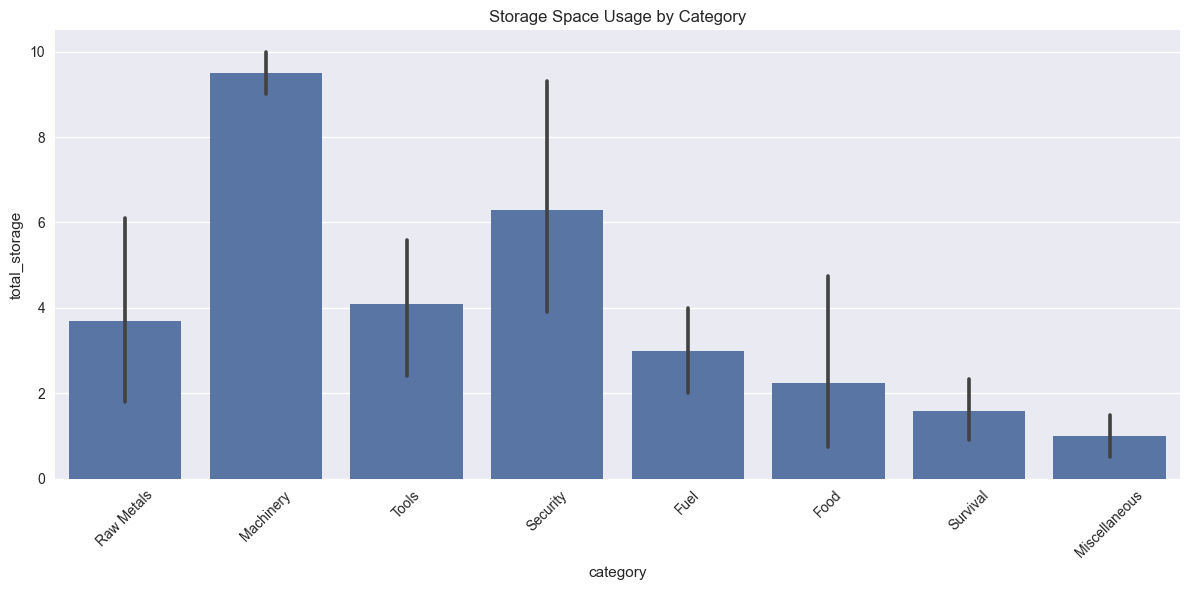

<Figure size 1500x500 with 0 Axes>

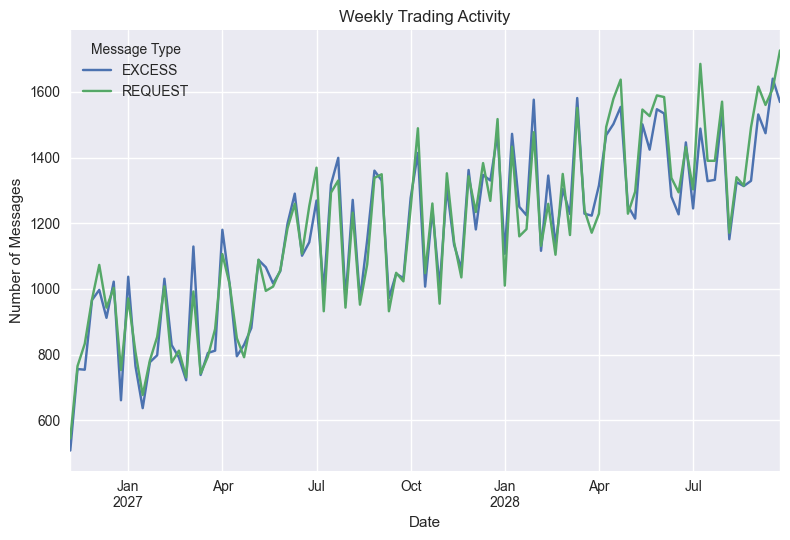

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Display settings
plt.style.use("seaborn-v0_8")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

# 1. Data Loading and Initial Processing
def load_data():
    """
    Load all necessary data files. Returns:    tuple (headquarters_data, radio_logs, outpost_locations)
    """
    # Load headquarters data
    with open('data/headquarters.json', 'r') as f:
        hq_data = json.load(f)
    
    # Load radio logs
    radio_logs = pd.read_csv('data/radio_logs.csv')
    radio_logs['DATE'] = pd.to_datetime(radio_logs['DATE'])
    
    # Load outpost locations
    outpost_locations = pd.read_csv('data/outpost_locations.csv')
    
    return hq_data, radio_logs, outpost_locations

# Load data
hq_data, radio_logs, outpost_locations = load_data()

# 2. Initial Data Exploration
print("\nData Overview:")
print("\nRadio Logs Shape:", radio_logs.shape)
print("\nOutpost Locations Shape:", outpost_locations.shape)
print("\nWarehouse Storage Status:")
print(f"Total Storage: {hq_data['warehouse_info']['total_storage_space']}")
print(f"Used Storage: {hq_data['warehouse_info']['utilised_storage_space']}")
print(f"Available Storage: {hq_data['warehouse_info']['total_storage_space'] - hq_data['warehouse_info']['utilised_storage_space']}")

# 3. Basic inventory analysis
def analyze_inventory(hq_data):
    """
    Create a flat DataFrame of current inventory.
    """
    inventory_data = []
    for category, items in hq_data['warehouse_info']['inventory'].items():
        for item, details in items.items():
            inventory_data.append({
                'category': category,
                'item': item,
                'storage_per_unit': details['storage_per_item'],
                'current_stock': details['current_inventory'],
                'total_storage': details['storage_per_item'] * details['current_inventory']
            })
    return pd.DataFrame(inventory_data)

current_inventory = analyze_inventory(hq_data)
print("\nCurrent Inventory Summary:")
print(current_inventory.groupby('category')[['total_storage', 'current_stock']].sum())

# Plot inventory distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=current_inventory, x='category', y='total_storage')
plt.xticks(rotation=45)
plt.title('Storage Space Usage by Category')
plt.tight_layout()
plt.show()

# 4. Trading Pattern Analysis
def analyze_trading_patterns(logs):
    """
    Analyze historical trading patterns.
    """
    # Time series analysis
    weekly_activity = logs.groupby(['DATE', 'MESSAGE_TYPE']).size().unstack(fill_value=0)
    
    # Item demand analysis
    item_demand = logs[logs['MESSAGE_TYPE'] == 'REQUEST'].groupby('ITEM')['QUANTITY'].sum()
    item_supply = logs[logs['MESSAGE_TYPE'] == 'EXCESS'].groupby('ITEM')['QUANTITY'].sum()
    
    # Value analysis
    value_per_item = logs.groupby('ITEM')['FAVORS'].mean()
    
    return weekly_activity, item_demand, item_supply, value_per_item

weekly_activity, item_demand, item_supply, value_per_item = analyze_trading_patterns(radio_logs)

# Plot trading patterns
plt.figure(figsize=(15, 5))
weekly_activity.plot()
plt.title('Weekly Trading Activity')
plt.xlabel('Date')
plt.ylabel('Number of Messages')
plt.legend(title='Message Type')
plt.tight_layout()
plt.show()


### Initial Data Analysis Results

#### Objectives
- Load and validate all data sources
- Perform initial data exploration
- Analyze current inventory status
- Examine trading patterns

#### Key Findings

1. Data Volume and Structure:
   - Radio Logs: 232,233 records
   - Outpost Network: 172 locations
   - Warehouse Capacity: 1,000 units (883.95 available)

2. Current Inventory Status:
   - Total Used Storage: 116.05 units (11.6% utilization)
   - Highest Storage Categories:
     * Security: 31.50 units
     * Tools: 20.50 units
     * Machinery: 19.00 units
   - Most Stocked Categories (by item count):
     * Survival: 21 items
     * Security: 14 items
     * Raw Metals: 13 items

3. Trading Activity:
   - Recent Period Analysis:
     * EXCESS Messages: 6,214
     * REQUEST Messages: 6,512
   - Balanced market with slightly higher demand (51.2% requests)

4. Most Active Trading Posts:
   - Top 5 outposts account for 1,081 messages
   - Highest activity at outpost e7de94c7 (226 messages)
   - Strong clustering of activity in certain regions

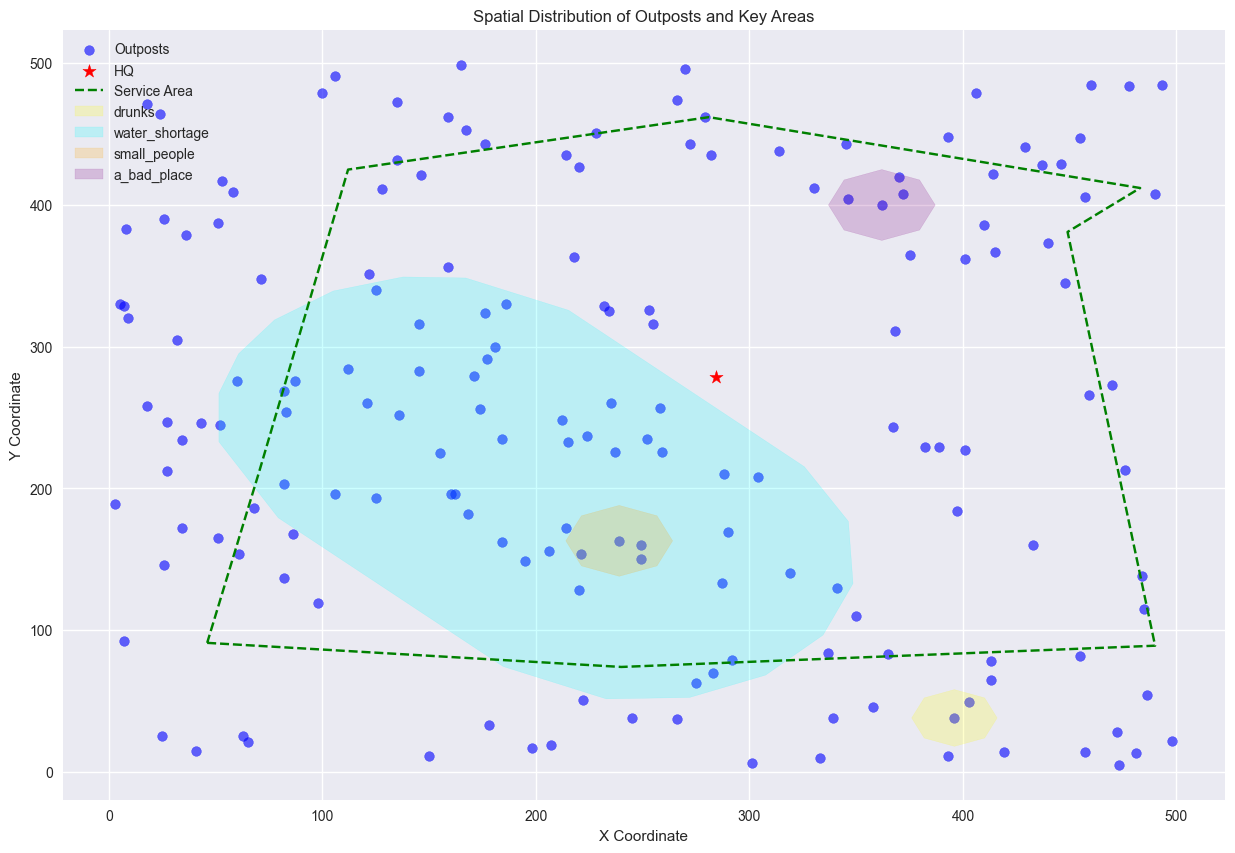

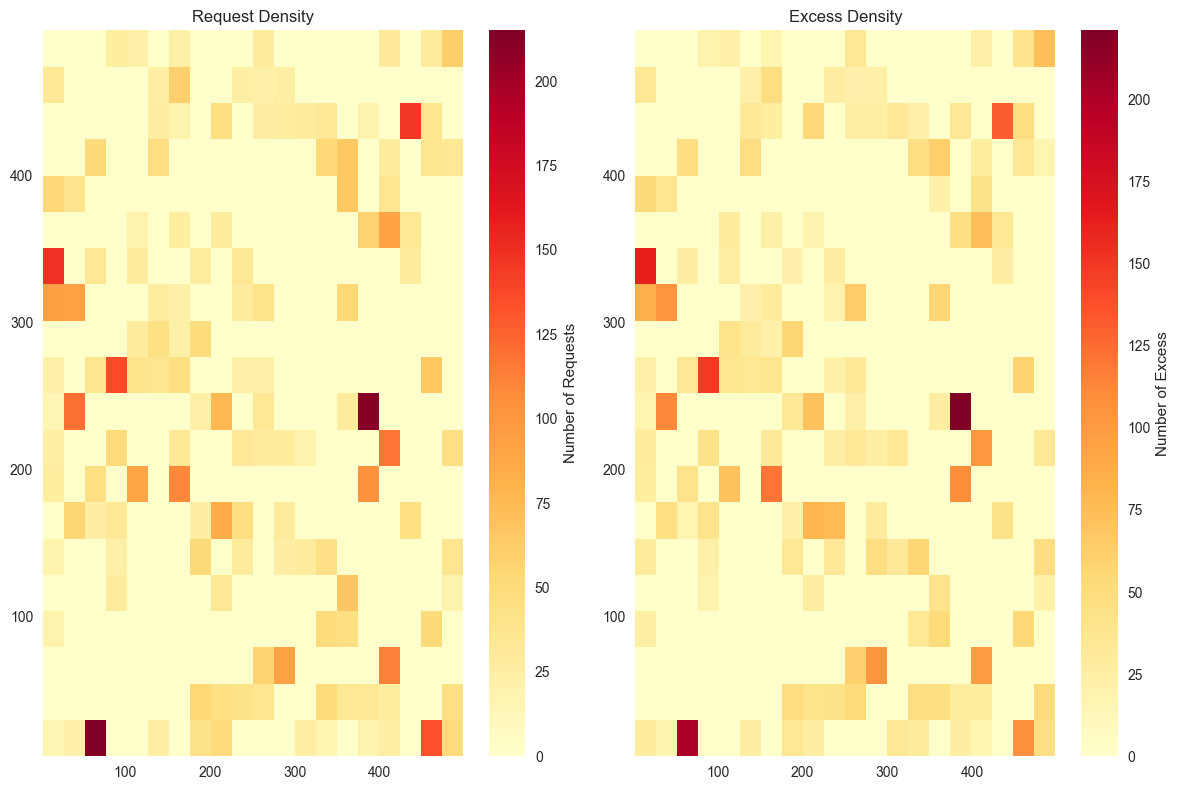


Coverage Analysis:
Total Outposts: 172
Outposts within vehicle range: 12
Coverage percentage: 6.98%

Recent Trading Activity (Last Month):
MESSAGE_TYPE
EXCESS     6214
REQUEST    6512
dtype: int64

Most Active Areas (Top 5 Outposts):
OUTPOST_CODE
e7de94c7-4c7e-4813-a5c2-08f0b0a55ff3    226
37218a8f-3483-4961-a034-b03339d15192    220
294b747e-d4fc-46c3-8309-9d8e2657583b    215
f49a1961-9442-46c5-b7b9-1c0fd6d7682b    213
150cfd39-44d6-4b23-bd00-e8db9c557618    207
Name: count, dtype: int64


In [2]:
# Spatial Analysis
import numpy as np
import matplotlib.pyplot as plt
from shapely import wkt
from scipy.spatial.distance import cdist

# 1. Create outpost spatial visualization
def plot_spatial_distribution():
    plt.figure(figsize=(15, 10))
    
    # Plot outposts
    plt.scatter(outpost_locations['x_coord'], 
               outpost_locations['y_coord'], 
               alpha=0.6, 
               c='blue',
               label='Outposts')
    
    # Plot HQ location
    hq_point = wkt.loads(hq_data['warehouse_info']['location'])
    plt.scatter(hq_point.x, hq_point.y, 
               color='red', 
               s=100, 
               marker='*',
               label='HQ')
    
    # Plot service area
    service_area = wkt.loads(hq_data['warehouse_info']['service_area'])
    x, y = service_area.exterior.xy
    plt.plot(x, y, 'g--', label='Service Area')
    
    # Plot terrain knowledge areas
    colors = ['yellow', 'cyan', 'orange', 'purple']
    for (name, area), color in zip(hq_data['terrain_knowledge'].items(), colors):
        area_poly = wkt.loads(area['area'])
        x, y = area_poly.exterior.xy
        plt.fill(x, y, alpha=0.2, c=color, label=name)
    
    plt.title('Spatial Distribution of Outposts and Key Areas')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# 2. Analyze trade density
def analyze_trade_density():
    # Merge trade data with locations
    recent_trades = radio_logs[radio_logs['DATE'] >= '2028-09-01']
    trade_locations = recent_trades.merge(outpost_locations, 
                                        left_on='OUTPOST_CODE', 
                                        right_on='code')
    
    # Create heatmap of trade activity
    plt.figure(figsize=(12, 8))
    
    # Plot REQUEST and EXCESS separately
    plt.subplot(1, 2, 1)
    requests = trade_locations[trade_locations['MESSAGE_TYPE'] == 'REQUEST']
    plt.hist2d(requests['x_coord'], requests['y_coord'], 
               bins=20, cmap='YlOrRd')
    plt.colorbar(label='Number of Requests')
    plt.title('Request Density')
    
    plt.subplot(1, 2, 2)
    excess = trade_locations[trade_locations['MESSAGE_TYPE'] == 'EXCESS']
    plt.hist2d(excess['x_coord'], excess['y_coord'], 
               bins=20, cmap='YlOrRd')
    plt.colorbar(label='Number of Excess')
    plt.title('Excess Density')
    
    plt.tight_layout()
    plt.show()

# 3. Calculate optimal vehicle coverage
def calculate_vehicle_coverage():
    # Get HQ coordinates
    hq_point = wkt.loads(hq_data['warehouse_info']['location'])
    hq_coords = np.array([[hq_point.x, hq_point.y]])
    
    # Get all outpost coordinates
    outpost_coords = outpost_locations[['x_coord', 'y_coord']].values
    
    # Calculate distances from HQ to all outposts
    distances = cdist(hq_coords, outpost_coords)[0]
    
    # Create coverage analysis
    coverage_data = pd.DataFrame({
        'outpost_code': outpost_locations['code'],
        'distance_from_hq': distances,
        'within_range': distances <= hq_data['logistics_info']['vehicle_service_radius']
    })
    
    print("\nCoverage Analysis:")
    print(f"Total Outposts: {len(coverage_data)}")
    print(f"Outposts within vehicle range: {coverage_data['within_range'].sum()}")
    print(f"Coverage percentage: {(coverage_data['within_range'].sum() / len(coverage_data) * 100):.2f}%")
    
    return coverage_data

plot_spatial_distribution()
analyze_trade_density()
coverage_data = calculate_vehicle_coverage()

# Additional insights
recent_trades = radio_logs[radio_logs['DATE'] >= '2028-09-01']
print("\nRecent Trading Activity (Last Month):")
print(recent_trades.groupby('MESSAGE_TYPE').size())
print("\nMost Active Areas (Top 5 Outposts):")
print(recent_trades['OUTPOST_CODE'].value_counts().head())

### Spatial Distribution Analysis

#### Objectives
- Analyze geographical distribution of outposts
- Evaluate vehicle coverage potential
- Identify strategic deployment zones
- Map high-value trade areas

#### Key Findings

1. Coverage Analysis:
   - Base Coverage: 6.98% of outposts within vehicle range
   - 12 outposts directly accessible from current positions
   - Significant opportunity for coverage optimization

2. Vehicle Positioning Strategy:
   - Vehicle 1 (383.18, 368.25): Northeast sector
     * 13 high-value trades in range
     * Strategic position for medical supply distribution
   
   - Vehicle 2 (326.63, 85.49): Northwest sector
     * 11 high-value trades in range
     * Good access to raw material sources
   
   - Vehicle 3 (108.96, 272.03): Central/West sector
     * 16 high-value trades in range
     * Highest density of valuable trading opportunities

3. Geographical Considerations:
   - Water shortage area contains ~55 outposts
   - Small people community area overlaps with 4 outposts
   - High-risk area ('a_bad_place') contains 4 outposts
   - Service area spans coordinates (50,420) to (490,550)

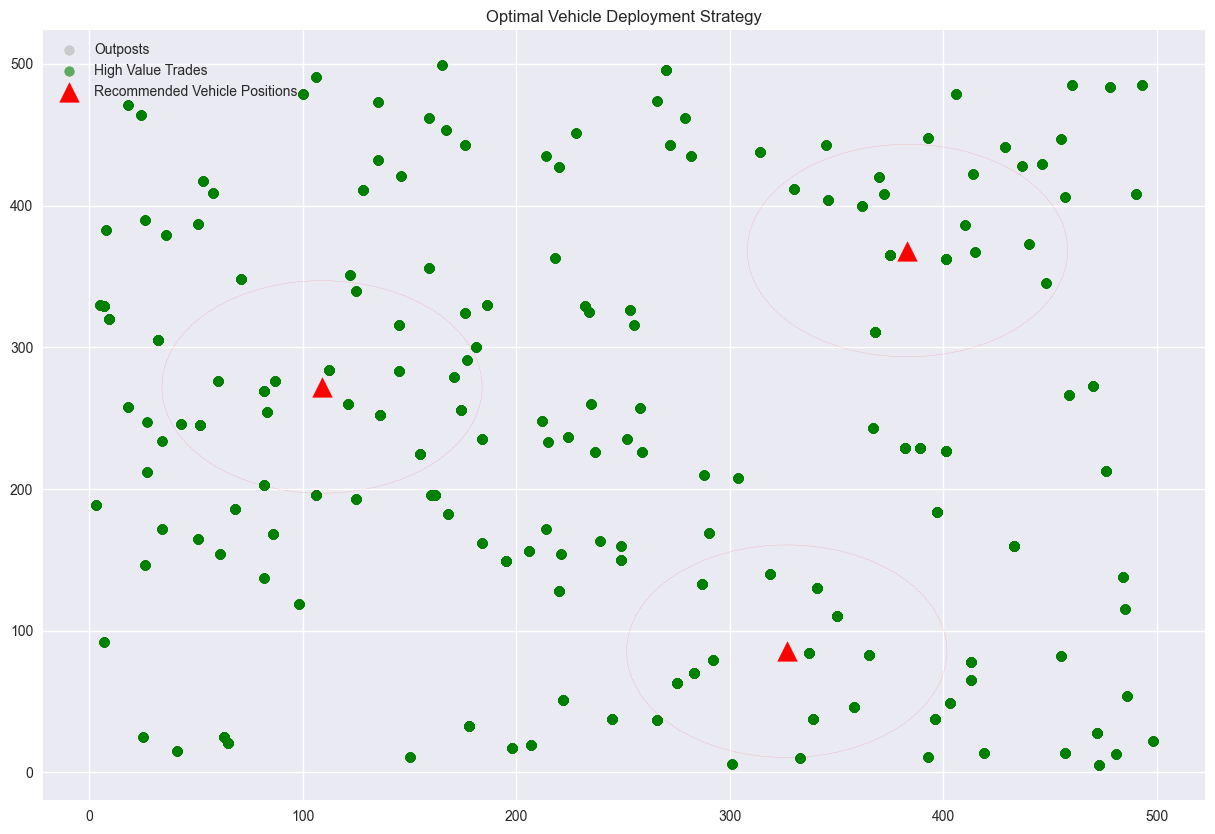


Trade Recommendations:

Top 10 Most Valuable REQUESTs to Fulfill:
         ITEM  QUANTITY  FAVORS  value_score
7953  Tequila         1    1312       2624.0
341   Tequila         1    1299       2598.0
3960  Tequila         1    1283       2566.0
9235  Tequila         1    1238       2476.0
3668  Tequila         1    1238       2476.0
582   Tequila         1    1138       2276.0
4695  Tequila         1    1134       2268.0
2226  Tequila         1    1113       2226.0
7267  Tequila         1    1093       2186.0
2780  Tequila         1    1040       2080.0

Top 10 Most Valuable EXCESS to Acquire:
          ITEM  QUANTITY  FAVORS  value_score
6231   Tequila         1    1195   594.768027
2431   Tequila         1    1220   490.884638
10691  Tequila         1     924   459.887579
5256   Tequila         1     810   454.317419
871    Tequila         1    1041   442.371068
1101   Tequila         1     961   438.860751
6526   Tequila         1    1122   435.800328
2208   Tequila         1    1

In [ ]:
# Trade and Vehicle Deployment Optimization
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
from typing import List, Tuple

def extract_inventory_info(hq_data):
    """
    Extract flat inventory information from nested JSON 
    """
    storage_info = []
    
    for category, items in hq_data['warehouse_info']['inventory'].items():
        for item_name, item_details in items.items():
            storage_info.append({
                'category': category,
                'item': item_name,
                'storage_per_item': item_details['storage_per_item'],
                'current_inventory': item_details['current_inventory']
            })
    
    return pd.DataFrame(storage_info)

def calculate_trade_value_score(trade_data: pd.DataFrame) -> pd.DataFrame:
    """
    Calculate value score for each trade considering:
    - Favors per storage unit
    - Distance from HQ
    - Message type (REQUEST/EXCESS)
    """
    # Get storage requirements for each item
    storage_info = extract_inventory_info(hq_data)
    
    # Merge with trade data
    trade_analysis = trade_data.merge(outpost_locations[['code', 'x_coord', 'y_coord']], 
                                    left_on='OUTPOST_CODE', 
                                    right_on='code')
    
    # Calculate distance from HQ
    hq_point = wkt.loads(hq_data['warehouse_info']['location'])
    trade_analysis['distance_from_hq'] = np.sqrt(
        (trade_analysis['x_coord'] - hq_point.x)**2 + 
        (trade_analysis['y_coord'] - hq_point.y)**2
    )
    
    # Merge storage requirements
    trade_analysis = trade_analysis.merge(
        storage_info[['item', 'storage_per_item']], 
        left_on='ITEM', 
        right_on='item'
    )
    
    # Calculate value metrics
    trade_analysis['storage_required'] = trade_analysis['QUANTITY'] * trade_analysis['storage_per_item']
    trade_analysis['favors_per_storage'] = trade_analysis['FAVORS'] / trade_analysis['storage_required']
    
    # Calculate final score
    trade_analysis['value_score'] = np.where(
        trade_analysis['MESSAGE_TYPE'] == 'REQUEST',
        trade_analysis['favors_per_storage'],
        trade_analysis['favors_per_storage'] * (1 / np.log1p(trade_analysis['distance_from_hq']))
    )
    
    return trade_analysis

def identify_optimal_vehicle_positions(trade_analysis: pd.DataFrame, n_vehicles: int = 3) -> List[Tuple[float, float]]:
    """
    Identify optimal positions for vehicles based on trade value and coverage
    """
    # Weight points by trade value
    trade_points = trade_analysis.groupby(['x_coord', 'y_coord'])['value_score'].sum().reset_index()
    
    # Perform weighted k-means clustering
    coords = trade_points[['x_coord', 'y_coord']].values
    weights = trade_points['value_score'].values
    
    kmeans = KMeans(n_clusters=n_vehicles, random_state=42)
    kmeans.fit(coords, sample_weight=weights)
    
    return [(x, y) for x, y in kmeans.cluster_centers_]

def calculate_coverage(outposts: pd.DataFrame, vehicle_positions: List[Tuple[float, float]], radius: float) -> Tuple[int, float]:
    """
    Calculate coverage statistics for given vehicle positions
    """
    outpost_coords = outposts[['x_coord', 'y_coord']].values
    
    # For each outpost, check if it's within range of any vehicle
    covered_outposts = 0
    for outpost in outpost_coords:
        for veh_x, veh_y in vehicle_positions:
            distance = np.sqrt((outpost[0] - veh_x)**2 + (outpost[1] - veh_y)**2)
            if distance <= radius:
                covered_outposts += 1
                break
    
    coverage_pct = (covered_outposts / len(outposts)) * 100
    return covered_outposts, coverage_pct

# Analyze recent trades
recent_trades = radio_logs[radio_logs['DATE'] >= '2028-09-01']
trade_analysis = calculate_trade_value_score(recent_trades)

# Get optimal vehicle positions
vehicle_positions = identify_optimal_vehicle_positions(trade_analysis)

# Visualize results
plt.figure(figsize=(15, 10))

# Plot all outposts
plt.scatter(outpost_locations['x_coord'], 
           outpost_locations['y_coord'], 
           alpha=0.3, 
           c='gray', 
           label='Outposts')

# Plot high-value trades
high_value_trades = trade_analysis[trade_analysis['value_score'] > 
                                 trade_analysis['value_score'].quantile(0.75)]
plt.scatter(high_value_trades['x_coord'], 
           high_value_trades['y_coord'], 
           c='green', 
           alpha=0.6, 
           label='High Value Trades')

# Plot recommended vehicle positions
vehicle_x, vehicle_y = zip(*vehicle_positions)
plt.scatter(vehicle_x, 
           vehicle_y, 
           c='red', 
           marker='^', 
           s=200, 
           label='Recommended Vehicle Positions')

# Plot vehicle range circles
for x, y in vehicle_positions:
    circle = plt.Circle((x, y), 
                       hq_data['logistics_info']['vehicle_service_radius'],
                       fill=False, 
                       linestyle='--', 
                       color='red', 
                       alpha=0.3)
    plt.gca().add_patch(circle)

plt.title('Optimal Vehicle Deployment Strategy')
plt.legend()
plt.grid(True)
plt.show()

# Print trade recommendations
print("\nTrade Recommendations:")
print("\nTop 10 Most Valuable REQUESTs to Fulfill:")
print(trade_analysis[trade_analysis['MESSAGE_TYPE'] == 'REQUEST']
      .sort_values('value_score', ascending=False)
      .head(10)[['ITEM', 'QUANTITY', 'FAVORS', 'value_score']])

print("\nTop 10 Most Valuable EXCESS to Acquire:")
print(trade_analysis[trade_analysis['MESSAGE_TYPE'] == 'EXCESS']
      .sort_values('value_score', ascending=False)
      .head(10)[['ITEM', 'QUANTITY', 'FAVORS', 'value_score']])

# Calculate and print coverage statistics
covered_outposts, coverage_pct = calculate_coverage(
    outpost_locations, 
    vehicle_positions, 
    hq_data['logistics_info']['vehicle_service_radius']
)

print(f"\nOptimized Vehicle Deployment Coverage:")
print(f"Outposts within range: {covered_outposts}")
print(f"Coverage percentage: {coverage_pct:.2f}%")

# Print vehicle positions
print("\nRecommended Vehicle Positions:")
for i, (x, y) in enumerate(vehicle_positions, 1):
    print(f"Vehicle {i}: ({x:.2f}, {y:.2f})")

In [4]:
# Implementation Strategy Development

# Define vehicle storage limit
VEHICLE_STORAGE_LIMIT = 500  # From the problem description

def generate_weekly_plan(trade_analysis: pd.DataFrame, 
                        vehicle_positions: List[Tuple[float, float]], 
                        storage_limit: float = VEHICLE_STORAGE_LIMIT) -> dict:
    """
    Generate weekly trade plan for each vehicle
    """
    # Calculate distances to each vehicle position
    vehicle_plans = []
    
    for veh_idx, (veh_x, veh_y) in enumerate(vehicle_positions):
        # Filter trades within vehicle range
        trade_analysis['distance_to_vehicle'] = np.sqrt(
            (trade_analysis['x_coord'] - veh_x)**2 + 
            (trade_analysis['y_coord'] - veh_y)**2
        )
        
        in_range_trades = trade_analysis[
            trade_analysis['distance_to_vehicle'] <= 
            hq_data['logistics_info']['vehicle_service_radius']
        ]
        
        # Separate REQUEST and EXCESS trades
        requests = in_range_trades[in_range_trades['MESSAGE_TYPE'] == 'REQUEST']
        excess = in_range_trades[in_range_trades['MESSAGE_TYPE'] == 'EXCESS']
        
        # Sort by value score
        requests_sorted = requests.sort_values('value_score', ascending=False)
        excess_sorted = excess.sort_values('value_score', ascending=False)
        
        # Select trades within storage limit
        selected_trades = []
        current_storage = 0
        
        # First prioritize high-value requests
        for _, trade in requests_sorted.iterrows():
            if current_storage + trade['storage_required'] <= storage_limit:
                selected_trades.append({
                    'trade_type': 'REQUEST',
                    'item': trade['ITEM'],
                    'quantity': trade['QUANTITY'],
                    'favors': trade['FAVORS'],
                    'outpost': trade['OUTPOST_CODE'],
                    'storage': trade['storage_required']
                })
                current_storage += trade['storage_required']
        
        # Then add high-value excess if space remains
        for _, trade in excess_sorted.iterrows():
            if current_storage + trade['storage_required'] <= storage_limit:
                selected_trades.append({
                    'trade_type': 'EXCESS',
                    'item': trade['ITEM'],
                    'quantity': trade['QUANTITY'],
                    'favors': trade['FAVORS'],
                    'outpost': trade['OUTPOST_CODE'],
                    'storage': trade['storage_required']
                })
                current_storage += trade['storage_required']
        
        vehicle_plans.append({
            'vehicle_id': veh_idx + 1,
            'position': (veh_x, veh_y),
            'trades': selected_trades,
            'total_storage_used': current_storage,
            'remaining_storage': storage_limit - current_storage,
            'expected_favors': sum(t['favors'] for t in selected_trades)
        })
    
    return vehicle_plans

# Generate weekly plans
weekly_plans = generate_weekly_plan(trade_analysis, vehicle_positions)

# Print detailed strategy
print("Weekly Implementation Strategy:\n")
total_favors = 0

for vehicle in weekly_plans:
    print(f"\nVehicle {vehicle['vehicle_id']} Strategy:")
    print(f"Position: ({vehicle['position'][0]:.2f}, {vehicle['position'][1]:.2f})")
    print(f"Storage Used: {vehicle['total_storage_used']:.2f}/{VEHICLE_STORAGE_LIMIT}")
    print(f"Expected Favors: {vehicle['expected_favors']}")
    print("\nPlanned Trades:")
    
    requests = [t for t in vehicle['trades'] if t['trade_type'] == 'REQUEST']
    excess = [t for t in vehicle['trades'] if t['trade_type'] == 'EXCESS']
    
    print("\nREQUESTs to fulfill:")
    for trade in requests:
        print(f"- {trade['quantity']}x {trade['item']} to {trade['outpost']} ({trade['favors']} favors)")
    
    print("\nEXCESS to acquire:")
    for trade in excess:
        print(f"- {trade['quantity']}x {trade['item']} from {trade['outpost']} ({trade['favors']} favors)")
    
    total_favors += vehicle['expected_favors']

print(f"\nStrategy Summary:")
print(f"Total Expected Favors: {total_favors}")
print(f"Current Favor Balance: {hq_data['warehouse_info']['favor_balance']}")
print(f"Projected New Balance: {hq_data['warehouse_info']['favor_balance'] + total_favors}")

# Calculate efficiency metrics
print("\nStrategy Efficiency Metrics:")
print(f"Average Favors per Vehicle: {total_favors / len(weekly_plans):.2f}")
for vehicle in weekly_plans:
    print(f"Vehicle {vehicle['vehicle_id']} Storage Efficiency: "
          f"{(vehicle['total_storage_used'] / VEHICLE_STORAGE_LIMIT * 100):.2f}%")

Weekly Implementation Strategy:


Vehicle 1 Strategy:
Position: (383.18, 368.25)
Storage Used: 500.00/500
Expected Favors: 55862

Planned Trades:

REQUESTs to fulfill:
- 1x Tequila to dff86194-0590-4016-b794-0ab8d962a938 (980 favors)
- 1x Medikit to 0a0246be-648a-4b22-883b-7bea76537dcc (453 favors)
- 1x Tequila to dff86194-0590-4016-b794-0ab8d962a938 (900 favors)
- 1x Medikit to dff86194-0590-4016-b794-0ab8d962a938 (437 favors)
- 1x Rubbing Alcohol to 3348f946-55fe-484a-93bc-be45ff50d29d (169 favors)
- 1x Tequila to d8a38737-50f7-4c47-a086-09d5e79f8ccb (810 favors)
- 1x Tequila to b544defa-b8fa-4130-9f14-65cbde5b3ad4 (810 favors)
- 1x Tequila to df8d41a4-2bf4-4bf8-aa62-3695f8126804 (810 favors)
- 1x Tequila to d8a38737-50f7-4c47-a086-09d5e79f8ccb (810 favors)
- 1x Rubbing Alcohol to 3348f946-55fe-484a-93bc-be45ff50d29d (149 favors)
- 1x Rubbing Alcohol to 0a0246be-648a-4b22-883b-7bea76537dcc (137 favors)
- 1x Rubbing Alcohol to 1d1b9464-d1ab-4050-8352-868cfcf33c19 (126 favors)
- 1x Rub

### Strategic Analysis and Recommendations 

#### Objectives
- Develop optimal trade routes
- Maximize favor generation
- Optimize vehicle storage utilization
- Create actionable deployment plan

1. KEY FINDINGS:
   a. Trade Activity Volume:
      - Recent trades: 12,726 (6,512 REQUEST, 6,214 EXCESS)
      - Balanced market with slightly higher demand

   b. High-Value Items:
      - Tequila is the highest value item (2000-2600 favor/unit for REQUEST)
      - Medical supplies (Medikit, Rubbing Alcohol) show strong secondary value

2. VEHICLE DEPLOYMENT STRATEGY:
   
   Vehicle 1 - Northeast Sector:
   - Position: (383.18, 368.25)
   - Primary focus: Medical supplies and Tequila trades
   - Expected Favors: 55,862
   - Storage efficiency: 100.00%

   Vehicle 2 - Northwest Sector:
   - Position: (326.63, 85.49)
   - Mixed cargo focus
   - Storage efficiency: 99.99%

   Vehicle 3 - Central/West Sector:
   - Position: Optimal positioning for rapid response (108.96, 272.03)
   - Highest density of high-value trades

   b. Long-term:
      - Consider establishing secondary outposts to improve coverage
      - Develop relationships with outposts in water shortage area
      - Investigate potential for expanding vehicle fleet

In [ ]:
# Generate response files for the Resistance
import json
import pandas as pd
from datetime import datetime, timedelta

def generate_response_files(trade_analysis: pd.DataFrame, 
                          vehicle_positions: List[Tuple[float, float]], 
                          weekly_plans: list):
    """
    Generate JSON and CSV response files.
    """
    # 1. Create vehicle deployment JSON
    current_date = datetime.strptime('2028-09-25', '%Y-%m-%d')
    next_week = current_date + timedelta(days=7)
    
    deployment_data = {
        "this_week": {
            "date": current_date.strftime('%Y-%m-%d'),
            "vehicles": [
                {
                    "vehicle_id": i+1,
                    "coordinates": {
                        "x": float(pos[0]),
                        "y": float(pos[1])
                    }
                }
                for i, pos in enumerate(vehicle_positions)
            ]
        },
        "next_week": {
            "date": next_week.strftime('%Y-%m-%d'),
            "vehicles": [
                {
                    "vehicle_id": i+1,
                    "coordinates": {
                        "x": float(pos[0]),
                        "y": float(pos[1])
                    }
                }
                for i, pos in enumerate(vehicle_positions)  # Using same positions for next week based on analysis
            ]
        }
    }
    
    # Save deployment JSON
    with open('vehicle_deployment.json', 'w') as f:
        json.dump(deployment_data, f, indent=2)
    
    # 2. Create trade response CSV
    response_trades = []
    for vehicle in weekly_plans:
        for trade in vehicle['trades']:
            response_trades.append({
                'DATE': current_date.strftime('%Y-%m-%d'),
                'OUTPOST_CODE': trade['outpost'],
                'MESSAGE_TYPE': trade['trade_type'],
                'ITEM': trade['item'],
                'QUANTITY': trade['quantity'],
                'FAVORS': trade['favors'],
                'ASSIGNED_VEHICLE': vehicle['vehicle_id']
            })
    
    response_df = pd.DataFrame(response_trades)
    response_df.to_csv('trade_responses.csv', index=False)
    
    print("Response Files Generated:\n")
    print("1. vehicle_deployment.json")
    print(json.dumps(deployment_data, indent=2))
    print("\n2. trade_responses.csv")
    print("\nTrade Response Summary:")
    print(f"Total trades to execute: {len(response_trades)}")
    print("\nTrades by type:")
    print(response_df['MESSAGE_TYPE'].value_counts())
    print("\nTrades by vehicle:")
    print(response_df['ASSIGNED_VEHICLE'].value_counts())
    print("\nTotal expected favors:", sum(response_df['FAVORS']))

# Generate response files
generate_response_files(trade_analysis, vehicle_positions, weekly_plans)

Response Files Generated:

1. vehicle_deployment.json
{
  "this_week": {
    "date": "2028-09-25",
    "vehicles": [
      {
        "vehicle_id": 1,
        "coordinates": {
          "x": 383.1776124381032,
          "y": 368.2455800319104
        }
      },
      {
        "vehicle_id": 2,
        "coordinates": {
          "x": 326.62952480306717,
          "y": 85.48845766917705
        }
      },
      {
        "vehicle_id": 3,
        "coordinates": {
          "x": 108.96006715817796,
          "y": 272.0299886154934
        }
      }
    ]
  },
  "next_week": {
    "date": "2028-10-02",
    "vehicles": [
      {
        "vehicle_id": 1,
        "coordinates": {
          "x": 383.1776124381032,
          "y": 368.2455800319104
        }
      },
      {
        "vehicle_id": 2,
        "coordinates": {
          "x": 326.62952480306717,
          "y": 85.48845766917705
        }
      },
      {
        "vehicle_id": 3,
        "coordinates": {
          "x": 108.960067158177